# Objective:

Understand the performance of `Calculator.zero_angle()` and get it working as well as possible.  We will:

0. Define a standard long-range rifle round to use throughout the study.
1. Compute the "reachable range" of the shot for launch angles from 0 to 90 degrees using `calc.find_max_range()`.  (This region is a convex hull.)
2. Sample target points within the reachable range and, for each point, determine how long it takes `.zero_angle()` to return the firing solution (i.e., the launch angle for a trajectory that will hit the point), and where it is unable to find a solution.

During the study we will use SciPy, but our goal is to have a `.zero_angle()` method that does not depend on SciPy and that can:
*  Calculate the zero angle for as large a region as possible, and 
*  Know where it won't work well – or at all.

(Note that in the `SciPyIntegrationEngine` the `._zero_angle()` method falls back on `._find_zero_angle()`, which uses SciPy's `root_scalar`.)

# Load

**Note extra Python package dependencies:**
* plotly
* shapely
* tqdm

In [1]:
import logging
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
from shapely.geometry import Point, Polygon
from py_ballisticcalc import Ammo, Atmo, Calculator, HitResult, Shot
from py_ballisticcalc import RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG7, logger, loadMetricUnits, ZeroFindingError
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire
from py_ballisticcalc.unit import *
logger.setLevel(logging.WARNING)
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
PreferredUnits.distance = Distance.Meter

def create_shot():
    """This is a standard 7.62mm NATO shot."""
    dm = DragModel(0.22, TableG7, Weight.Gram(10), Distance.Centimeter(7.62), Distance.Centimeter(3.0))
    ammo = Ammo(dm, Velocity.MPS(800))
    return Shot(ammo=ammo, atmo=Atmo.icao())
shot = create_shot()
calc = Calculator(engine="scipy_engine")

## Example

In [4]:
# Here's how to get the max range at a particular slant angle
shot.slant_angle = Angular.Degree(15)
max_range, angle_to_reach = calc.find_max_range(shot)
print(f"Max range for target at look-angle {shot.slant_angle >> Angular.Degree:.2f}° "
      f"is {max_range >> Distance.Meter:.2f}m. Launch angle to hit is {angle_to_reach >> Angular.Degree:.2f}°.")

Max range for target at look-angle 15.00° is 3901.71m. Launch angle to hit is 43.44°.


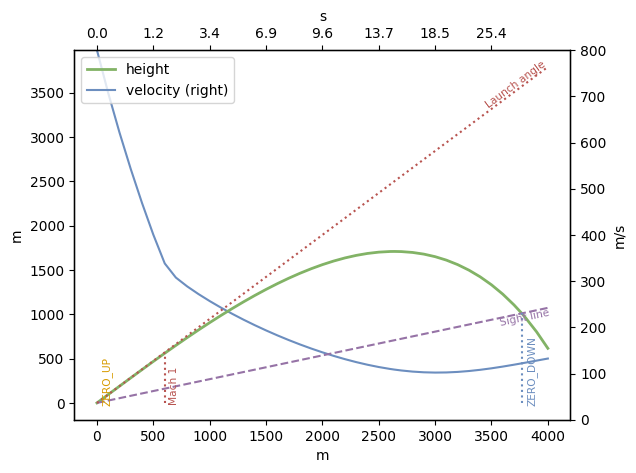

In [5]:
# Confirm the finding:
shot.barrel_elevation = angle_to_reach
trajectory, e = must_fire(calc, shot, trajectory_range=Distance.Meter((max_range >> Distance.Meter)+100), trajectory_step=Distance.Meter(100), extra_data=True)
trajectory.plot()
# Slant height at the target distance should be approximately zero (within a small tolerance)
slant_zero = trajectory.flag(TrajFlag.ZERO_DOWN)
assert abs(slant_zero.slant_distance.raw_value - max_range.raw_value) < 1e-6
assert abs(slant_zero.slant_height.raw_value) < 1e-6 

# Find Reachable Range Envelope
For slant angles from 0-90°.

In [7]:
# Calculate the max range for a variety of slant angles to map the envelope.
slant_angles_deg = np.linspace(0, 90, 45)
envelope_points = []
shot = create_shot()
for slant_angle_deg in tqdm(slant_angles_deg, desc="Slant angles"):
    shot.slant_angle = Angular.Degree(slant_angle_deg)
    try:
        max_dist, launch_angle = calc.find_max_range(shot)
        
        slant_angle_rad = shot.slant_angle >> Angular.Radian
        x = (max_dist >> Distance.Meter) * math.cos(slant_angle_rad)
        y = (max_dist >> Distance.Meter) * math.sin(slant_angle_rad)
        
        envelope_points.append({
            'slant_angle_deg': slant_angle_deg,
            'launch_angle_deg': launch_angle >> Angular.Degree,
            'max_dist_m': max_dist >> Distance.Meter,
            'x': x,
            'y': y
        })
    except Exception as e:
        print(f"Could not determine range for slant angle {slant_angle_deg:.1f}: {e}")

envelope_df = pd.DataFrame(envelope_points)
display(envelope_df.head())
display(envelope_df.tail())
# --- Visualize the envelope ---
fig = px.line(
    envelope_df.sort_values('slant_angle_deg'), 
    x='x', 
    y='y', 
    title='Reachable Range Envelope',
    labels={'x': 'Horizontal Distance (m)', 'y': 'Vertical Distance (m)'},
    hover_data=['slant_angle_deg', 'launch_angle_deg', 'max_dist_m']
)
fig.update_layout(
    yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
    xaxis=dict(constrain='domain'),
    title_x=0.5,
    margin=dict(t=50)
)
fig.show()

Slant angles:   0%|          | 0/45 [00:00<?, ?it/s]

,slant_angle_deg,launch_angle_deg,max_dist_m,x,y
0,0.000000,35.917251,4342.467980,4342.467980,0.000000
1,2.045455,36.879046,4272.432402,4269.710117,152.493084
2,4.090909,37.861827,4205.872699,4195.156617,300.043523
3,6.136364,38.865930,4142.545827,4118.810290,442.817940
4,8.181818,39.889468,4082.315532,4040.763446,580.974075


,slant_angle_deg,launch_angle_deg,max_dist_m,x,y
40,81.818182,84.614508,3148.938862,4.481407e+02,3116.887205
41,83.863636,85.815760,3139.987086,3.356493e+02,3121.995908
42,85.909091,87.184203,3134.217217,2.235925e+02,3126.231591
43,87.954545,88.585893,3130.802815,1.117457e+02,3128.807948
44,90.000000,90.000000,3141.485247,1.923605e-13,3141.485247


# Define sample region

In [8]:
def get_sample_points(envelope_df, min_distance: float=500, lin_density: int=50, extreme_only: bool=False):
    """Generate sample points within the reachable range envelope."""
    # Create a polygon from the envelope
    x_min, x_max = 0., envelope_df['x'].max()
    y_min, y_max = 0., envelope_df['y'].max()
    if extreme_only:  # Only cover points outside the chord
        envelope = envelope_df[['x', 'y']].values
    else:
        envelope = np.vstack([[0, 0], envelope_df[['x', 'y']].values])
    envelope_polygon = Polygon(envelope)

    x_points = np.linspace(x_min, x_max, lin_density)
    y_points = np.linspace(y_min, y_max, lin_density)
    test_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)

    # Filter points that are inside the envelope
    use_points = []
    for p in test_points:
        point = Point(p)
        if point.within(envelope_polygon) and point.distance(Point(0,0)) > min_distance:
            use_points.append({'x': p[0], 'y': p[1]})

    return use_points

def plot_sample_points(envelope_df, point_list):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=envelope_df['x'], y=envelope_df['y'], mode='lines', name='Envelope', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=point_list['x'], y=point_list['y'], mode='markers', name='Test Points', marker=dict(size=2)))
    fig.update_layout(
        title=str(len(point_list))+' Selected Test Points within Envelope',
        yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
        xaxis=dict(constrain='domain', range=[0, envelope_df['x'].max()]),
        title_x=0.5,
        margin=dict(t=50)
    )
    fig.show()

## Small Sample (400 pts)

In [12]:
small_sample = get_sample_points(envelope_df, min_distance=1950, lin_density=30)
plot_sample_points(envelope_df, pd.DataFrame(small_sample))

## Big Sample (5,000 pts)

In [21]:
big_sample = get_sample_points(envelope_df, min_distance=400, lin_density=86)
plot_sample_points(envelope_df, pd.DataFrame(big_sample))

## Huge Sample (20,000 pts)

In [24]:
huge_sample = get_sample_points(envelope_df, min_distance=0, lin_density=169)
plot_sample_points(envelope_df, pd.DataFrame(huge_sample))

# Baseline

## Engine Constraints

The iterative zeroing algorithm takes a test shot (starting with launch angle equal to the slant angle to the target), observes how far the projectile was from the target when it reached the slant distance, and then calculates an adjustment based on that.  A degenerate case occurs when the calculator isn't allowed to compute the trajectory all the way to the slant distance.  So first let's check how much drop we need to allow the calculator to see in the most extreme case.

_When we launch at a look angle of zero: How far do we drop before reaching max horizontal distance of this projectile?_

In [25]:
max_x_m = envelope_df.x.max()
max_x = Distance.Meter(max_x_m)
max_x_ft = max_x >> Distance.Foot
conf = BaseEngineConfigDict(
    cMinimumVelocity=0,
    cMinimumAltitude=-max_x_ft/2.0,
    cMaximumDrop=max_x_ft/2.0,
)
calc = Calculator(config=conf, engine="scipy_engine")
t, e = must_fire(calc, create_shot(), trajectory_range=max_x, trajectory_step=max_x)
if e is not None:
    print(f"Error: {e}")
print(f'Max horizontal range is {max_x_m:.2f}m.  Launching at 0°, when trajectory x={t[-1].distance >> Distance.Meter:.2f}m, y={t[-1].height >> Distance.Meter:.2f}m')

Max horizontal range is 4342.47m.  Launching at 0°, when trajectory x=4342.47m, y=-2078.12m


Conclusion: **On the longest possible shot, we can reach the target horizontal distance when launching from look angle if calculator is allowed to drop half the horizontal distance.**  For the consequences of not allowing it to drop this far see the [Test No Drop](#test-no-drop) section.

## Define Zero Test Function

In [26]:
def zero_test(x_m: float, y_m: float, max_iterations: int=50, cZeroFindingAccuracy: float=0.000005, calc_config=None):
    target_dist = Distance.Meter(math.sqrt(x_m**2 + y_m**2))
    slant_range_ft = target_dist >> Distance.Foot
    slant_angle_rad = math.atan2(y_m, x_m)
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle

    target_x_ft = Distance.Meter(x_m) >> Distance.Foot
    iterations_count = 0
    range_error_ft = 9e9  # Absolute value of error from target distance along sight line
    prev_range_error_ft = 9e9
    prev_height_error_ft = 9e9
    damping_factor = 1.0  # Start with no damping
    damping_rate = 0.7  # Damping rate for correction
    last_correction = 0.0
    height_error_ft = cZeroFindingAccuracy * 2  # Absolute value of error from sight line in feet at zero distance
    warned = False
    sensitive = []  # Record sensitive values encountered
    damping = []  # Record damping values applied

    if calc_config is None:
        calc_config = BaseEngineConfigDict(
            cMinimumVelocity=0,
            cMinimumAltitude=-target_x_ft/2.0,
            cMaximumDrop=target_x_ft/2.0,
        )
    calc = Calculator(config=calc_config, engine="scipy_engine")
    props = calc._init_trajectory(shot)

    while iterations_count < max_iterations:
        iterations_count += 1
        try:
            t = calc._integrate(props, target_x_ft, target_x_ft, TrajFlag.NONE)[-1]
            height_diff_ft = t.slant_height >> Distance.Foot
            look_dist_ft = t.slant_distance >> Distance.Foot
            range_diff_ft = look_dist_ft - slant_range_ft
            range_error_ft = math.fabs(range_diff_ft)
            height_error_ft = math.fabs(height_diff_ft)
            trajectory_angle = t.angle >> Angular.Radian  # Trajectory angle at target distance
            sensitivity = math.tan(props.barrel_elevation_rad - slant_angle_rad) * math.tan(trajectory_angle - slant_angle_rad)
            if sensitivity < -0.5:
                sensitive.append(sensitivity)
                if not warned:
                    logger.info(f"Sensitivity {sensitivity} critical for point ({x_m}, {y_m}) after {iterations_count} iterations")
                    warned = True
                denominator = look_dist_ft
            else:
                denominator = look_dist_ft * (1 + sensitivity)
            if abs(denominator) > 1e-9:
                correction = -height_diff_ft / denominator
            else:
                raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                      'Correction denominator is zero')

            if range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # We're still trying to reach zero_distance
                if range_error_ft > prev_range_error_ft - 1e-6:  # We're not getting closer to zero_distance
                    raise ZeroFindingError(range_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Distance non-convergent')
            elif height_error_ft > math.fabs(prev_height_error_ft):  # Error is increasing, we are diverging
                damping_factor *= damping_rate  # Apply damping to prevent overcorrection
                if damping_factor < 0.3:
                    raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Error non-convergent')
                logger.info(f'Tightened damping factor to {damping_factor:.2f} for point ({x_m}, {y_m}) after {iterations_count} iterations')
                damping.append(damping_factor)
                props.barrel_elevation_rad -= last_correction  # Revert previous adjustment
                correction = last_correction
            elif damping_factor < 1.0:
                logger.info(f'Reseting damping factor to 1.0 at iteration {iterations_count}')
                damping_factor = 1.0

            prev_range_error_ft = range_error_ft
            prev_height_error_ft = height_error_ft

            if height_error_ft > cZeroFindingAccuracy or range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # Adjust barrel elevation to reduce error at zero distance
                applied_correction = correction * damping_factor
                props.barrel_elevation_rad += applied_correction
                last_correction = applied_correction
            else:  # We are close enough to zero, stop iterating
                result = {
                    'x': x_m,
                    'y': y_m,
                    'iterations': iterations_count,
                    'solution': props.barrel_elevation_rad,
                    'sensitivity': sensitive,
                    'damping': damping,
                    'error': None
                }
                break
        except Exception as e:
            result = {
                'x': x_m,
                'y': y_m,
                'iterations': iterations_count,
                'solution': None,
                'sensitivity': sensitive,
                'damping': damping,
                'error': e
            }
            break
    if iterations_count >= max_iterations:
        result = {
            'x': x_m,
            'y': y_m,
            'iterations': iterations_count,
            'solution': None,
            'sensitivity': sensitive,
            'damping': damping,
            'error': 'Max iterations reached'
        }
    return result

## Define Visualization

In [27]:
def plot_test_results(df, envelope_df):
    """Plot the results of zero finding tests."""
    fig = go.Figure()
    converged_df = df[df['solution'].notna()].copy()
    failed_df = df[df['solution'].isna()].copy()

    if not converged_df.empty:
        heatmap_data = converged_df.pivot_table(index='y', columns='x', values='iterations', aggfunc='mean')
        fig.add_trace(
            go.Heatmap(
                z=heatmap_data.values,
                x=heatmap_data.columns,
                y=heatmap_data.index,
                colorscale=[[0.0, "#00FF00"], [0.3, "#6969FF"], [1.0, "#FF0000"]],
                colorbar=dict(title='Iterations', x=.85),
                name='Converged',
                hoverongaps=False,
                hovertemplate='x: %{x}<br>y: %{y}<br>iterations: %{z}<extra></extra>'
            )
        )
    if not failed_df.empty:
        fig.add_trace(  # Add failed points, colored white
            go.Scatter(
                x=failed_df['x'],
                y=failed_df['y'],
                mode='markers',
                marker=dict(color='white', symbol='square', size=7, line=dict(color='black', width=1)),
                name='Failed to converge',
                hoverinfo='text',
                text=[f"x: {r['x']:.2f}<br>y: {r['y']:.2f}<br>{r['error']}" for i, r in failed_df.iterrows()]
            )
        )
    fig.add_trace(  # Add the reachable envelope
        go.Scatter(
            x=envelope_df['x'], 
            y=envelope_df['y'], 
            mode='lines', 
            name='Reachable Envelope',
            line=dict(color='black', width=2)
        )
    )
    fig.update_layout(
        title='Iterations to find zero across Reachable Range',
        xaxis_title='Horizontal Distance to Target (m)',
        yaxis_title='Vertical Distance to Target (m)',
        yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
        xaxis=dict(constrain='domain'),
        title_x=0.5,
        legend=dict(x=1, y=1, traceorder='normal', title_text='Result'),
        showlegend=True,
        margin=dict(t=50)
    )
    fig.show()
    return fig

## Baseline (small sample)

In [28]:
results = []
df = pd.DataFrame(small_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_small_df = pd.DataFrame(results)
baseline_small_df.to_csv('ZeroSmallBaseline.csv')

  0%|          | 0/400 [00:00<?, ?it/s]

### Plot Small Baseline

In [29]:
p = plot_test_results(baseline_small_df, envelope_df)
p.write_html('ZeroBaselineSmallChart.html')

## Baseline (big sample)

See how the current algorithm performes when the calculator is allowed sufficient drop to reach the target horizontal distance when launched at the slant angle.

In [30]:
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_big_df = pd.DataFrame(results)
baseline_big_df.to_csv('ZeroBigBaseline.csv')

  0%|          | 0/4995 [00:00<?, ?it/s]

### Plot

In [31]:
p = plot_test_results(baseline_big_df, envelope_df)
p.write_html('ZeroBaselineChart.html')

## Baseline (huge sample)

In [32]:
results = []
df = pd.DataFrame(huge_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_huge_df = pd.DataFrame(results)
baseline_huge_df.to_csv('ZeroHugeBaseline.csv')

  0%|          | 0/19901 [00:00<?, ?it/s]

### Plot

In [33]:
p = plot_test_results(baseline_huge_df, envelope_df)
p.write_html('ZeroBaselineHugeChart.html')

## Test No Drop
Stop the integrator at ground level.

In [17]:
conf = BaseEngineConfigDict(
    cMinimumAltitude=0,
    cMaximumDrop=0,
)
results = []
df = pd.DataFrame(small_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y'], calc_config=conf))
no_drop_df = pd.DataFrame(results)

  0%|          | 0/389 [00:00<?, ?it/s]

### Plot

In [18]:
p = plot_test_results(no_drop_df, envelope_df)

## Sensitivity Limit

What if we bound the sensitivity term at 0, instead of letting it go as low as -0.5?

In [19]:
def zero_test_sensitivity_limit(x_m: float, y_m: float, sensitivity_limit: float=-0.5, max_iterations: int=50, cZeroFindingAccuracy: float=0.000005, calc_config=None):
    target_dist = Distance.Meter(math.sqrt(x_m**2 + y_m**2))
    slant_range_ft = target_dist >> Distance.Foot
    slant_angle_rad = math.atan2(y_m, x_m)
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle

    target_x_ft = Distance.Meter(x_m) >> Distance.Foot
    iterations_count = 0
    range_error_ft = 9e9  # Absolute value of error from target distance along sight line
    prev_range_error_ft = 9e9
    prev_height_error_ft = 9e9
    damping_factor = 1.0  # Start with no damping
    damping_rate = 0.7  # Damping rate for correction
    last_correction = 0.0
    height_error_ft = cZeroFindingAccuracy * 2  # Absolute value of error from sight line in feet at zero distance
    warned = False
    sensitive = []  # Record sensitive values encountered
    damping = []  # Record damping values applied

    if calc_config is None:
        calc_config = BaseEngineConfigDict(
            cMinimumVelocity=0,
            cMinimumAltitude=-target_x_ft/2.0,
            cMaximumDrop=target_x_ft/2.0,
        )
    calc = Calculator(config=calc_config, engine="scipy_engine")
    props = calc._init_trajectory(shot)

    while iterations_count < max_iterations:
        iterations_count += 1
        try:
            t = calc._integrate(props, target_x_ft, target_x_ft, TrajFlag.NONE)[-1]
            height_diff_ft = t.slant_height >> Distance.Foot
            look_dist_ft = t.slant_distance >> Distance.Foot
            range_diff_ft = look_dist_ft - slant_range_ft
            range_error_ft = math.fabs(range_diff_ft)
            height_error_ft = math.fabs(height_diff_ft)
            trajectory_angle = t.angle >> Angular.Radian  # Trajectory angle at target distance
            sensitivity = math.tan(props.barrel_elevation_rad - slant_angle_rad) * math.tan(trajectory_angle - slant_angle_rad)
            if sensitivity < sensitivity_limit:
                sensitive.append(sensitivity)
                if not warned:
                    logger.info(f"Sensitivity {sensitivity} critical for point ({x_m}, {y_m}) after {iterations_count} iterations")
                    warned = True
                denominator = look_dist_ft
            else:
                denominator = look_dist_ft * (1 + sensitivity)
            if abs(denominator) > 1e-9:
                correction = -height_diff_ft / denominator
            else:
                raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                      'Correction denominator is zero')

            if range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # We're still trying to reach zero_distance
                if range_error_ft > prev_range_error_ft - 1e-6:  # We're not getting closer to zero_distance
                    raise ZeroFindingError(range_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Distance non-convergent')
            elif height_error_ft > math.fabs(prev_height_error_ft):  # Error is increasing, we are diverging
                damping_factor *= damping_rate  # Apply damping to prevent overcorrection
                if damping_factor < 0.3:
                    raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Error non-convergent')
                logger.info(f'Tightened damping factor to {damping_factor:.2f} for point ({x_m}, {y_m}) after {iterations_count} iterations')
                damping.append(damping_factor)
                props.barrel_elevation_rad -= last_correction # Revert previous adjustment
                correction = last_correction
            elif damping_factor < 1.0:
                logger.info(f'Reseting damping factor to 1.0 at iteration {iterations_count}')
                damping_factor = 1.0

            prev_range_error_ft = range_error_ft
            prev_height_error_ft = height_error_ft

            if height_error_ft > cZeroFindingAccuracy or range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # Adjust barrel elevation to reduce error at zero distance
                applied_correction = correction * damping_factor
                props.barrel_elevation_rad += applied_correction
                last_correction = applied_correction
            else:  # We are close enough to zero, stop iterating
                result = {
                    'x': x_m,
                    'y': y_m,
                    'iterations': iterations_count,
                    'solution': props.barrel_elevation_rad,
                    'sensitivity': sensitive,
                    'damping': damping,
                    'error': None
                }
                break
        except Exception as e:
            result = {
                'x': x_m,
                'y': y_m,
                'iterations': iterations_count,
                'solution': None,
                'sensitivity': sensitive,
                'damping': damping,
                'error': e
            }
            break
    if iterations_count >= max_iterations:
        result = {
            'x': x_m,
            'y': y_m,
            'iterations': iterations_count,
            'solution': None,
            'sensitivity': sensitive,
            'damping': damping,
            'error': 'Max iterations reached'
        }
    return result

In [20]:
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test_sensitivity_limit(point['x'], point['y'], sensitivity_limit=0.0))
sensitivity_positive_df = pd.DataFrame(results)
sensitivity_positive_df.to_csv('ZeroSensitivityPositive.csv')
p = plot_test_results(sensitivity_positive_df, envelope_df)
p.write_html('ZeroSensitivityPositiveChart.html')

  0%|          | 0/4910 [00:00<?, ?it/s]

# SciPy iterations

For comparison, how many trajectory calculations does `scipy_engine.find_zero_angle()` take?

In [ ]:
from scipy.optimize import root_scalar
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    target_dist = Distance.Meter(math.sqrt(point['x']**2 + point['y']**2))
    target_x_ft = Distance.Meter(point['x']) >> Distance.Foot
    target_y_ft = Distance.Meter(point['y']) >> Distance.Foot  # Target height in feet
    slant_range_ft = target_dist >> Distance.Foot  # Slant range in feet
    slant_angle_rad = math.atan2(point['y'], point['x'])
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle
    props = calc._init_trajectory(shot)
    start_count = calc.trajectory_count
    max_range, angle_at_max = calc._find_max_range(props)

    def error_at_distance(angle_rad: float) -> float:
        """Target miss (in feet) for launch at <angle_rad>."""
        props.barrel_elevation_rad = angle_rad
        try:
            # Integrate to find the projectile's state at the target's horizontal distance.
            t = calc._integrate(props, target_x_ft, target_x_ft, TrajFlag.NONE)[-1]
        except RangeError as e:
            if e.last_distance is None:
                raise e
            t = e.incomplete_trajectory[-1]
        if t.time == 0.0:
            logger.warning("Integrator returned initial point. Consider removing constraints.")
            return -1e6  # Large negative error to discourage this angle.
        # return -abs(t.slant_height >> Distance.Foot) - abs((t.slant_distance >> Distance.Foot) - slant_range_ft)
        return (t.height >> Distance.Foot) - target_y_ft - abs((t.distance >> Distance.Foot) - target_x_ft)

    angle_bracket = (props.look_angle_rad, angle_at_max >> Angular.Radian)
    try:
        sol = root_scalar(error_at_distance, bracket=angle_bracket, method='brentq')
        if not sol.converged:
            # raise ZeroFindingError(target_y_ft, 0, Angular.Radian(props.barrel_elevation_rad),
            #                         reason=f"Root-finder failed to converge: {sol.flag} with {sol}")
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': None,
                'error': f"Root-finder failed to converge: {sol.flag} with {sol}"
            }
        else:
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': sol.root,
                'error': None
            }
        results.append(result)
    except ValueError as e:
        # raise ZeroFindingError(target_y_ft, 0, Angular.Radian(props.barrel_elevation_rad),
        #                         reason=f"No zero trajectory in elevation range " +
        #                                 f"({Angular.Radian(angle_bracket[0]) >> Angular.Degree}," +
        #                                 f" {Angular.Radian(angle_bracket[1]) >> Angular.Degree} degrees. {e}")
        result = {
            'x': point['x'],
            'y': point['y'],
            'iterations': calc.trajectory_count - start_count,
            'solution': None,
            'error': "No solution found"
        }
        results.append(result)

scipy_df = pd.DataFrame(results)
scipy_df.to_csv('ZeroSciPy.csv')

  0%|          | 0/4910 [00:00<?, ?it/s]

### Plot

In [ ]:
p = plot_test_results(scipy_df, envelope_df)
p.write_html('ZeroSciPyChart.html')

# SciPy (huge sample)

In [34]:
from scipy.optimize import root_scalar
results = []
df = pd.DataFrame(huge_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    target_dist = Distance.Meter(math.sqrt(point['x']**2 + point['y']**2))
    target_x_ft = Distance.Meter(point['x']) >> Distance.Foot
    target_y_ft = Distance.Meter(point['y']) >> Distance.Foot  # Target height in feet
    slant_range_ft = target_dist >> Distance.Foot  # Slant range in feet
    slant_angle_rad = math.atan2(point['y'], point['x'])
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle
    props = calc._init_trajectory(shot)
    start_count = calc.trajectory_count
    max_range, angle_at_max = calc._find_max_range(props)

    def error_at_distance(angle_rad: float) -> float:
        """Target miss (in feet) for launch at <angle_rad>."""
        props.barrel_elevation_rad = angle_rad
        try:
            # Integrate to find the projectile's state at the target's horizontal distance.
            t = calc._integrate(props, target_x_ft, target_x_ft, TrajFlag.NONE)[-1]
        except RangeError as e:
            if e.last_distance is None:
                raise e
            t = e.incomplete_trajectory[-1]
        if t.time == 0.0:
            logger.warning("Integrator returned initial point. Consider removing constraints.")
            return -1e6  # Large negative error to discourage this angle.
        # return -abs(t.slant_height >> Distance.Foot) - abs((t.slant_distance >> Distance.Foot) - slant_range_ft)
        return (t.height >> Distance.Foot) - target_y_ft - abs((t.distance >> Distance.Foot) - target_x_ft)

    angle_bracket = (props.look_angle_rad, angle_at_max >> Angular.Radian)
    try:
        sol = root_scalar(error_at_distance, bracket=angle_bracket, method='brentq')
        if not sol.converged:
            # raise ZeroFindingError(target_y_ft, 0, Angular.Radian(props.barrel_elevation_rad),
            #                         reason=f"Root-finder failed to converge: {sol.flag} with {sol}")
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': None,
                'error': f"Root-finder failed to converge: {sol.flag} with {sol}"
            }
        else:
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': sol.root,
                'error': None
            }
        results.append(result)
    except ValueError as e:
        # raise ZeroFindingError(target_y_ft, 0, Angular.Radian(props.barrel_elevation_rad),
        #                         reason=f"No zero trajectory in elevation range " +
        #                                 f"({Angular.Radian(angle_bracket[0]) >> Angular.Degree}," +
        #                                 f" {Angular.Radian(angle_bracket[1]) >> Angular.Degree} degrees. {e}")
        result = {
            'x': point['x'],
            'y': point['y'],
            'iterations': calc.trajectory_count - start_count,
            'solution': None,
            'error': "No solution found"
        }
        results.append(result)

scipy_df = pd.DataFrame(results)
scipy_df.to_csv('ZeroSciPyHuge.csv')

  0%|          | 0/19901 [00:00<?, ?it/s]

## Plot

In [35]:
p = plot_test_results(scipy_df, envelope_df)
p.write_html('ZeroSciPyChartHuge.html')